# **Setup (Install + Imports)**

### **Install libraries**

In [1]:
!pip -q install pandas numpy matplotlib scikit-learn scipy joblib

### **Imports**

In [2]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

import joblib

plt.rcParams["figure.figsize"] = (9, 5)

# **Load Dataset**

In [3]:
DATA_PATH = "/content/Food_Production.csv"
df = pd.read_csv(DATA_PATH)
df.head()

,Food product,Land use change,Animal Feed,Farm,Processing,Transport,Packging,Retail,Total_emissions,Eutrophying emissions per 1000kcal (gPO₄eq per 1000kcal),...,Freshwater withdrawals per 100g protein (liters per 100g protein),Freshwater withdrawals per kilogram (liters per kilogram),Greenhouse gas emissions per 1000kcal (kgCO₂eq per 1000kcal),Greenhouse gas emissions per 100g protein (kgCO₂eq per 100g protein),Land use per 1000kcal (m² per 1000kcal),Land use per kilogram (m² per kilogram),Land use per 100g protein (m² per 100g protein),Scarcity-weighted water use per kilogram (liters per kilogram),Scarcity-weighted water use per 100g protein (liters per 100g protein),Scarcity-weighted water use per 1000kcal (liters per 1000 kilocalories)
0,Wheat & Rye (Bread),0.1,0.0,0.8,0.2,0.1,0.1,0.1,1.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Maize (Meal),0.3,0.0,0.5,0.1,0.1,0.1,0.0,1.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Barley (Beer),0.0,0.0,0.2,0.1,0.0,0.5,0.3,1.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Oatmeal,0.0,0.0,1.4,0.0,0.1,0.1,0.0,1.6,4.281357,...,371.076923,482.4,0.945482,1.907692,2.897446,7.6,5.846154,18786.2,14450.92308,7162.104461
4,Rice,0.0,0.0,3.6,0.1,0.1,0.1,0.1,4.0,9.514379,...,3166.760563,2248.4,1.207271,6.267606,0.759631,2.8,3.943662,49576.3,69825.77465,13449.891480


### **Basic checks**

In [4]:
print("Shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())
df.info()

Shape: (43, 23)

Columns:
 ['Food product', 'Land use change', 'Animal Feed', 'Farm', 'Processing', 'Transport', 'Packging', 'Retail', 'Total_emissions', 'Eutrophying emissions per 1000kcal (gPO₄eq per 1000kcal)', 'Eutrophying emissions per kilogram (gPO₄eq per kilogram)', 'Eutrophying emissions per 100g protein (gPO₄eq per 100 grams protein)', 'Freshwater withdrawals per 1000kcal (liters per 1000kcal)', 'Freshwater withdrawals per 100g protein (liters per 100g protein)', 'Freshwater withdrawals per kilogram (liters per kilogram)', 'Greenhouse gas emissions per 1000kcal (kgCO₂eq per 1000kcal)', 'Greenhouse gas emissions per 100g protein (kgCO₂eq per 100g protein)', 'Land use per 1000kcal (m² per 1000kcal)', 'Land use per kilogram (m² per kilogram)', 'Land use per 100g protein (m² per 100g protein)', 'Scarcity-weighted water use per kilogram (liters per kilogram)', 'Scarcity-weighted water use per 100g protein (liters per 100g protein)', 'Scarcity-weighted water use per 1000kcal (liters

# **Clean Column Names**

In [5]:
df.columns = (
    df.columns
    .astype(str)
    .str.strip()
    .str.replace("\n", " ", regex=False)
)

# Rename only the ID column to make coding easier (optional but recommended)
df = df.rename(columns={"Food product": "Food_product"})

# Quick verification
print("Updated columns:")
print(df.columns.tolist())

Updated columns:
['Food_product', 'Land use change', 'Animal Feed', 'Farm', 'Processing', 'Transport', 'Packging', 'Retail', 'Total_emissions', 'Eutrophying emissions per 1000kcal (gPO₄eq per 1000kcal)', 'Eutrophying emissions per kilogram (gPO₄eq per kilogram)', 'Eutrophying emissions per 100g protein (gPO₄eq per 100 grams protein)', 'Freshwater withdrawals per 1000kcal (liters per 1000kcal)', 'Freshwater withdrawals per 100g protein (liters per 100g protein)', 'Freshwater withdrawals per kilogram (liters per kilogram)', 'Greenhouse gas emissions per 1000kcal (kgCO₂eq per 1000kcal)', 'Greenhouse gas emissions per 100g protein (kgCO₂eq per 100g protein)', 'Land use per 1000kcal (m² per 1000kcal)', 'Land use per kilogram (m² per kilogram)', 'Land use per 100g protein (m² per 100g protein)', 'Scarcity-weighted water use per kilogram (liters per kilogram)', 'Scarcity-weighted water use per 100g protein (liters per 100g protein)', 'Scarcity-weighted water use per 1000kcal (liters per 1000 

# **Convert Numeric Columns Properly**

In [6]:
TARGET = "Total_emissions"
id_col = "Food_product"

# Convert all non-ID columns to numeric safely
for col in df.columns:
    if col != id_col:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Quick check
print("Dataset shape:", df.shape)
print("Top missing-value columns:")
print(df.isna().sum().sort_values(ascending=False).head(10))

Dataset shape: (43, 23)
Top missing-value columns:
Freshwater withdrawals per 100g protein (liters per 100g protein)          17
Scarcity-weighted water use per 100g protein (liters per 100g protein)     17
Greenhouse gas emissions per 100g protein (kgCO₂eq per 100g protein)       16
Eutrophying emissions per 100g protein (gPO₄eq per 100 grams protein)      16
Land use per 100g protein (m² per 100g protein)                            16
Scarcity-weighted water use per 1000kcal (liters per 1000 kilocalories)    13
Freshwater withdrawals per 1000kcal (liters per 1000kcal)                  13
Greenhouse gas emissions per 1000kcal (kgCO₂eq per 1000kcal)               10
Land use per 1000kcal (m² per 1000kcal)                                    10
Eutrophying emissions per 1000kcal (gPO₄eq per 1000kcal)                   10
dtype: int64


# **EDA**

### **Top 10 foods by total emissions**

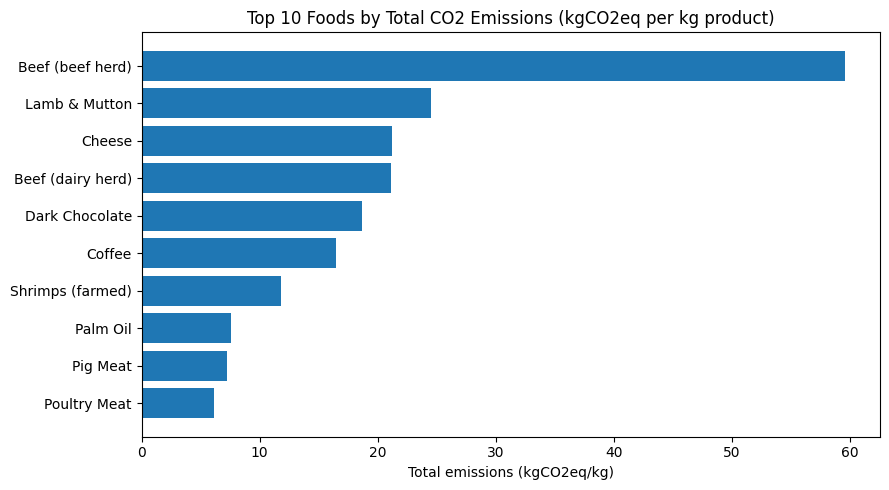

In [7]:
top10 = df[[id_col, TARGET]].dropna().sort_values(TARGET, ascending=False).head(10)

plt.figure()
plt.barh(top10[id_col][::-1], top10[TARGET][::-1])
plt.title("Top 10 Foods by Total CO2 Emissions (kgCO2eq per kg product)")
plt.xlabel("Total emissions (kgCO2eq/kg)")
plt.tight_layout()
plt.show()

### **Correlation heatmap-style (simple, no seaborn)**

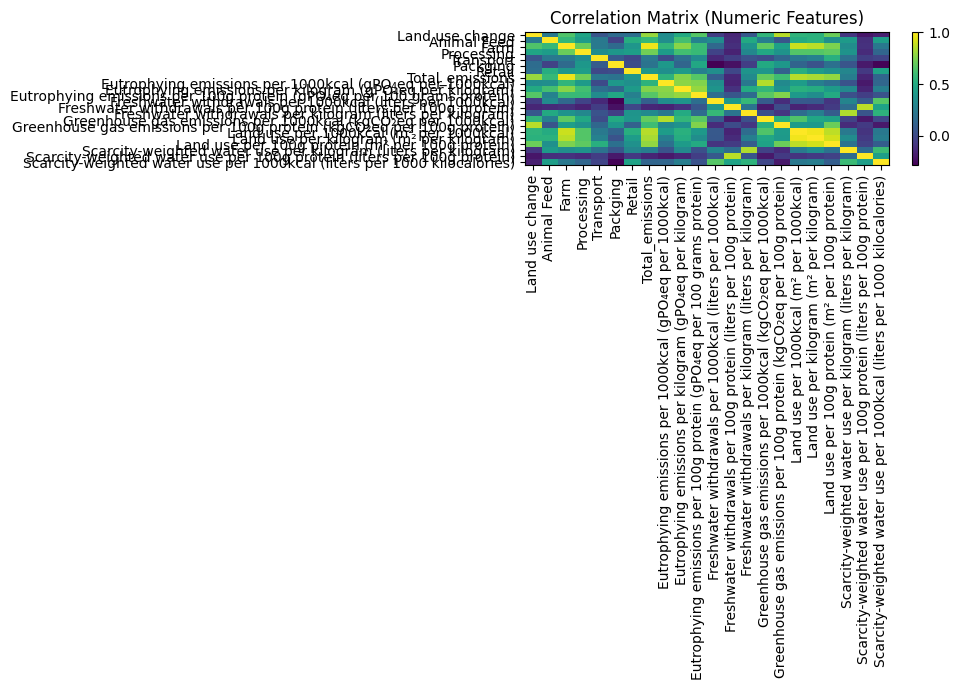

In [8]:
num_df = df.drop(columns=[id_col])
corr = num_df.corr(numeric_only=True)

plt.figure(figsize=(10, 7))
plt.imshow(corr, aspect="auto")
plt.title("Correlation Matrix (Numeric Features)")
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.tight_layout()
plt.show()

### **Lifecycle Stage Columns**

In [9]:
stage_cols = [
    "Land use change",
    "Animal Feed",
    "Farm",
    "Processing",
    "Transport",
    "Packging",
    "Retail"
]

# Safety check (confirms columns exist)
missing = [c for c in stage_cols if c not in df.columns]
print("Missing stage columns:", missing)
print("Stage columns confirmed:", [c for c in stage_cols if c in df.columns])

Missing stage columns: []
Stage columns confirmed: ['Land use change', 'Animal Feed', 'Farm', 'Processing', 'Transport', 'Packging', 'Retail']


# **Feature Engineering**

In [10]:
df_fe = df.copy()

# Avoid divide by zero
df_fe["Stage_sum"] = df_fe[stage_cols].sum(axis=1)

for c in stage_cols:
    df_fe[f"{c}_share"] = np.where(df_fe["Stage_sum"] > 0,
                                  df_fe[c] / df_fe["Stage_sum"],
                                  np.nan)

df_fe[[id_col, "Stage_sum"] + [f"{c}_share" for c in stage_cols]].head()


,Food_product,Stage_sum,Land use change_share,Animal Feed_share,Farm_share,Processing_share,Transport_share,Packging_share,Retail_share
0,Wheat & Rye (Bread),1.4,0.071429,0.0,0.571429,0.142857,0.071429,0.071429,0.071429
1,Maize (Meal),1.1,0.272727,0.0,0.454545,0.090909,0.090909,0.090909,0.000000
2,Barley (Beer),1.1,0.000000,0.0,0.181818,0.090909,0.000000,0.454545,0.272727
3,Oatmeal,1.6,0.000000,0.0,0.875000,0.000000,0.062500,0.062500,0.000000
4,Rice,4.0,0.000000,0.0,0.900000,0.025000,0.025000,0.025000,0.025000


### **Simple “Food Type” label (Plant vs Animal) for analysis**

In [11]:
animal_keywords = [
    "beef", "lamb", "pork", "chicken", "turkey", "fish", "prawns", "shrimp",
    "milk", "cheese", "eggs", "yogurt", "butter"
]

def label_food_type(name: str) -> str:
    n = str(name).lower()
    return "Animal-based" if any(k in n for k in animal_keywords) else "Plant-based"

df_fe["Food_type"] = df_fe[id_col].apply(label_food_type)
df_fe["Food_type"].value_counts()

,count
Food_type,
Plant-based,34
Animal-based,9


# **Model 1 — Regression (Predict Total Emissions from Lifecycle Stages)**

In [12]:
X = df_fe[stage_cols].copy()
y = df_fe[TARGET].copy()

# Keep rows with target
mask = y.notna()
X = X.loc[mask]
y = y.loc[mask]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (32, 7) Test: (11, 7)


### **Baseline + Strong model (Ridge + RandomForest)**

In [13]:
ridge_model = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0, random_state=42))
])

rf_model = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("model", RandomForestRegressor(
        n_estimators=400,
        random_state=42,
        max_depth=None
    ))
])

ridge_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

def eval_reg(model, X_te, y_te, name="model"):
    preds = model.predict(X_te)
    mae = mean_absolute_error(y_te, preds)
    rmse = mean_squared_error(y_te, preds) ** 0.5
    r2 = r2_score(y_te, preds)
    print(f"{name} -> MAE: {mae:.3f} | RMSE: {rmse:.3f} | R2: {r2:.3f}")
    return preds

pred_ridge = eval_reg(ridge_model, X_test, y_test, "Ridge")
pred_rf    = eval_reg(rf_model, X_test, y_test, "RandomForest")

Ridge -> MAE: 0.331 | RMSE: 0.487 | R2: 0.996
RandomForest -> MAE: 0.989 | RMSE: 1.376 | R2: 0.966


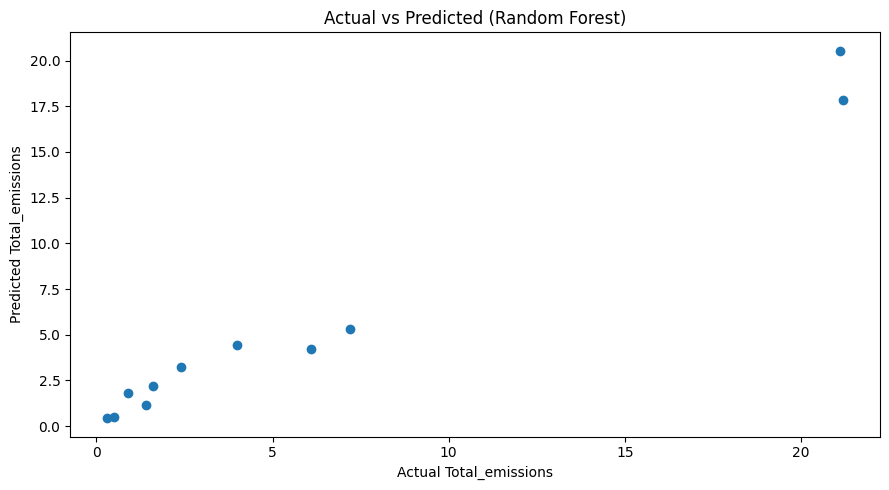

In [14]:
plt.figure()
plt.scatter(y_test, pred_rf)
plt.xlabel("Actual Total_emissions")
plt.ylabel("Predicted Total_emissions")
plt.title("Actual vs Predicted (Random Forest)")
plt.tight_layout()
plt.show()

### **Cross-validation**

In [15]:
cv_scores = cross_val_score(
    rf_model, X, y, cv=5, scoring="neg_mean_absolute_error"
)
print("RF CV MAE (mean):", -cv_scores.mean())
print("RF CV MAE (std): ", cv_scores.std())

RF CV MAE (mean): 2.5120201388888894
RF CV MAE (std):  2.6078615345755094


### **Feature importance**

Farm               0.563680
Land use change    0.317490
Processing         0.060984
Animal Feed        0.025813
Packging           0.020885
Transport          0.008713
Retail             0.002434
dtype: float64


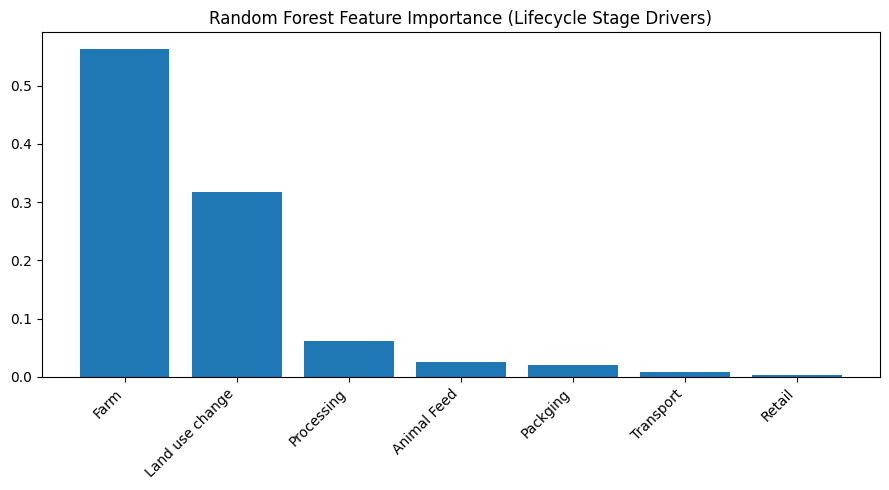

In [16]:
rf = rf_model.named_steps["model"]
importances = pd.Series(rf.feature_importances_, index=stage_cols).sort_values(ascending=False)
print(importances)

plt.figure()
plt.bar(importances.index, importances.values)
plt.title("Random Forest Feature Importance (Lifecycle Stage Drivers)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# **Model 2 — Clustering Foods into Sustainability Groups**

### **Build clustering features**

In [17]:
cluster_features = [TARGET] + stage_cols
C = df_fe[[id_col] + cluster_features].dropna().copy()

Xc = C[cluster_features].values
scaler = StandardScaler()
Xc_scaled = scaler.fit_transform(Xc)

### **Choose k (Elbow plot)**

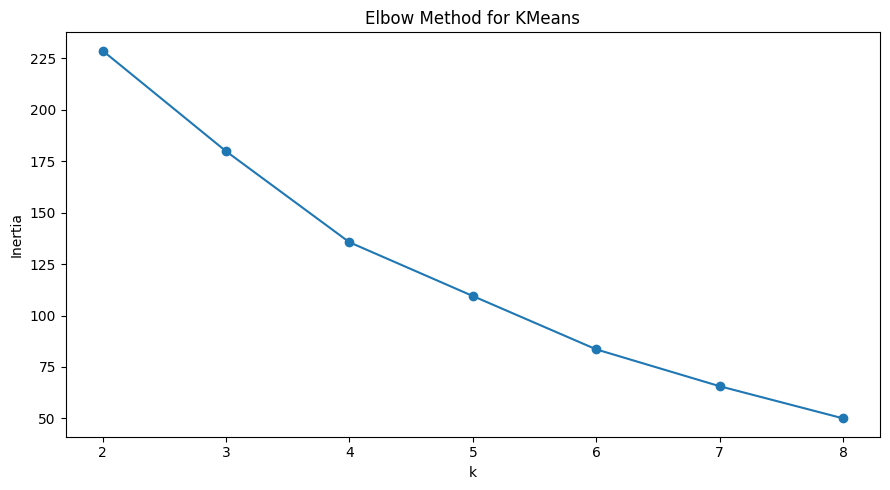

In [18]:
inertias = []
ks = range(2, 9)

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(Xc_scaled)
    inertias.append(km.inertia_)

plt.figure()
plt.plot(list(ks), inertias, marker="o")
plt.title("Elbow Method for KMeans")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.tight_layout()
plt.show()

### **Final clustering + interpretation table**

In [19]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
C["Cluster"] = kmeans.fit_predict(Xc_scaled)

cluster_summary = C.groupby("Cluster")[cluster_features].mean().sort_values(TARGET)
cluster_counts = C["Cluster"].value_counts().sort_index()

print("Cluster counts:\n", cluster_counts)
print("\nCluster summary (means):\n", cluster_summary)

cluster_summary

Cluster counts:
 Cluster
0     7
1    29
2     1
3     6
Name: count, dtype: int64

Cluster summary (means):
          Total_emissions  Land use change  Animal Feed       Farm  Processing  \
Cluster                                                                         
1               1.493103         0.127586     0.110345   0.837931    0.086207   
0               8.857143         3.442857     0.000000   3.771429    0.500000   
3              15.316667         1.683333     2.400000   9.850000    0.600000   
2              59.600000        16.300000     1.900000  39.400000    1.300000   

         Transport  Packging    Retail  
Cluster                                 
1         0.162069  0.120690  0.048276  
0         0.228571  0.900000  0.014286  
3         0.300000  0.266667  0.216667  
2         0.300000  0.200000  0.200000  


,Total_emissions,Land use change,Animal Feed,Farm,Processing,Transport,Packging,Retail
Cluster,,,,,,,,
1,1.493103,0.127586,0.110345,0.837931,0.086207,0.162069,0.120690,0.048276
0,8.857143,3.442857,0.000000,3.771429,0.500000,0.228571,0.900000,0.014286
3,15.316667,1.683333,2.400000,9.850000,0.600000,0.300000,0.266667,0.216667
2,59.600000,16.300000,1.900000,39.400000,1.300000,0.300000,0.200000,0.200000


### **Visualize clusters using PCA (2D)**

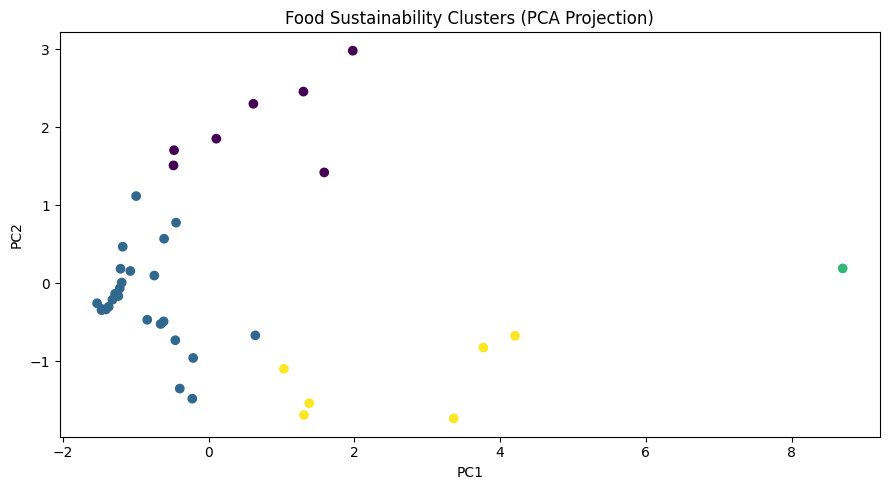

In [20]:
pca = PCA(n_components=2, random_state=42)
X2 = pca.fit_transform(Xc_scaled)

plt.figure()
plt.scatter(X2[:,0], X2[:,1], c=C["Cluster"].values)
plt.title("Food Sustainability Clusters (PCA Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

# **Model 3 — Recommendation System (Suggest Lower-Carbon Alternatives)**

### **Build recommendation space**

In [21]:
rec_cols_candidates = [
    "Total_emissions",
    "Greenhouse gas emissions per 1000kcal (kgCO₂eq per 1000kcal)",
    "Freshwater withdrawals per 1000kcal (liters per 1000kcal)",
    "Land use per 1000kcal (m² per 1000kcal)"
]

rec_cols = [c for c in rec_cols_candidates if c in df.columns]

R = df[[id_col] + rec_cols].dropna().copy()

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

scaler_rec = StandardScaler()
Xr = scaler_rec.fit_transform(R[rec_cols].values)

nn = NearestNeighbors(n_neighbors=6, metric="euclidean")
nn.fit(Xr)

print("Recommendation features used:", rec_cols)
print("Rows in recommender table:", R.shape[0])

Recommendation features used: ['Total_emissions', 'Greenhouse gas emissions per 1000kcal (kgCO₂eq per 1000kcal)', 'Freshwater withdrawals per 1000kcal (liters per 1000kcal)', 'Land use per 1000kcal (m² per 1000kcal)']
Rows in recommender table: 30


### **Function: recommend alternatives with lower total emissions**

In [22]:
def recommend_alternatives(food_name: str, top_n: int = 5):
    # Find exact match
    if food_name not in set(R[id_col]):
        # Try partial matching
        matches = R[R[id_col].str.contains(food_name, case=False, na=False)][id_col].tolist()
        return {
            "error": f"Food not found. Try one of these close matches: {matches[:10]}"
        }

    idx = R.index[R[id_col] == food_name][0]
    row_pos = R.index.get_loc(idx)

    distances, indices = nn.kneighbors(Xr[row_pos:row_pos+1], n_neighbors=top_n+1)
    neighbor_positions = indices[0].tolist()

    # Remove self (first neighbor is itself)
    neighbor_positions = [p for p in neighbor_positions if p != row_pos]

    base_em = float(R.iloc[row_pos][TARGET]) if TARGET in rec_cols else None

    recs = []
    for p in neighbor_positions:
        cand = R.iloc[p]
        cand_em = float(cand[TARGET]) if TARGET in rec_cols else None

        # prefer lower-carbon options if target exists
        recs.append({
            "Food": cand[id_col],
            "Total_emissions": cand_em
        })

    recs_df = pd.DataFrame(recs)
    if "Total_emissions" in recs_df.columns and base_em is not None:
        recs_df["Lower_than_selected"] = recs_df["Total_emissions"] < base_em
        recs_df = recs_df.sort_values(["Lower_than_selected", "Total_emissions"], ascending=[False, True])

    return {
        "selected_food": food_name,
        "selected_total_emissions": base_em,
        "recommendations": recs_df.head(top_n)
    }

# Example
recommend_alternatives("Rice", top_n=5)


{'selected_food': 'Rice',
 'selected_total_emissions': 4.0,
 'recommendations':                Food  Total_emissions  Lower_than_selected
 0              Nuts              0.2                 True
 4            Apples              0.3                 True
 2         Brassicas              0.4                 True
 1  Berries & Grapes              1.1                 True
 3              Eggs              4.5                False}

In [23]:
out = recommend_alternatives("Rice", top_n=5)

if "error" not in out:
    recs = out["recommendations"].copy()
    base = out["selected_total_emissions"]
    recs["%_reduction_vs_selected"] = ((base - recs["Total_emissions"]) / base) * 100
    display(recs)
else:
    print(out["error"])

,Food,Total_emissions,Lower_than_selected,%_reduction_vs_selected
0,Nuts,0.2,True,95.0
4,Apples,0.3,True,92.5
2,Brassicas,0.4,True,90.0
1,Berries & Grapes,1.1,True,72.5
3,Eggs,4.5,False,-12.5


# **Save Outputs**

### **Save cleaned dataset**

In [24]:
os.makedirs("outputs", exist_ok=True)

df_fe.to_csv("outputs/food_production_cleaned.csv", index=False)
print("Saved:", "outputs/food_production_cleaned.csv")

Saved: outputs/food_production_cleaned.csv


### **Save models**

In [25]:
joblib.dump(rf_model, "outputs/emissions_rf_model.joblib")
joblib.dump(kmeans, "outputs/food_kmeans_model.joblib")
joblib.dump(scaler, "outputs/cluster_scaler.joblib")
joblib.dump(nn, "outputs/recommender_nn.joblib")
joblib.dump(scaler_rec, "outputs/recommender_scaler.joblib")

print("Saved models in outputs/")

Saved models in outputs/


# **Mini “Application Demo”**

In [26]:
!pip install streamlit


In [27]:
# Install required packages
!pip install -q streamlit

# Create the Streamlit app file
streamlit_code = '''
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

st.set_page_config(
    page_title="AI for Sustainability Food Carbon Footprint",
    page_icon="leaf",
    layout="wide"
)

st.markdown("""
    <style>
    .main {
        padding: 0rem 1rem;
    }
    h1 {
        color: #2E7D32;
    }
    h2 {
        color: #388E3C;
    }
    </style>
    """, unsafe_allow_html=True)

@st.cache_data
def load_data():
    df = pd.read_csv("/content/outputs/food_production_cleaned.csv")
    return df

@st.cache_resource
def load_models():
    rf_model = joblib.load("/content/outputs/emissions_rf_model.joblib")
    kmeans = joblib.load("/content/outputs/food_kmeans_model.joblib")
    cluster_scaler = joblib.load("/content/outputs/cluster_scaler.joblib")
    nn = joblib.load("/content/outputs/recommender_nn.joblib")
    rec_scaler = joblib.load("/content/outputs/recommender_scaler.joblib")
    return rf_model, kmeans, cluster_scaler, nn, rec_scaler

try:
    df = load_data()
    rf_model, kmeans, cluster_scaler, nn, rec_scaler = load_models()

    rec_cols_candidates = [
        "Total_emissions",
        "Greenhouse gas emissions per 1000kcal (kgCO₂eq per 1000kcal)",
        "Freshwater withdrawals per 1000kcal (liters per 1000kcal)",
        "Land use per 1000kcal (m² per 1000kcal)"
    ]
    rec_cols = [c for c in rec_cols_candidates if c in df.columns]
    R = df[["Food_product"] + rec_cols].dropna().copy()

    stage_cols = [
        "Land use change",
        "Animal Feed",
        "Farm",
        "Processing",
        "Transport",
        "Packging",
        "Retail"
    ]

except Exception as e:
    st.error(f"Error loading data or models: {e}")
    st.stop()

st.sidebar.title("Navigation")
page = st.sidebar.radio(
    "Select a Page:",
    ["Home", "Food Explorer", "Emission Predictor", "Sustainability Clusters", "Smart Recommendations", "Analytics Dashboard"]
)

st.sidebar.markdown("---")
st.sidebar.info(
    "About this App: This AI powered system helps you understand and reduce your carbon footprint "
    "through food choices. Explore emissions data, get personalized recommendations, "
    "and make sustainable decisions."
)

if page == "Home":
    st.title("AI for Sustainability Food Carbon Footprint Analysis")
    st.markdown("### Making Sustainable Food Choices with Artificial Intelligence")

    col1, col2, col3, col4 = st.columns(4)

    with col1:
        st.metric("Total Foods Analyzed", len(df))
    with col2:
        avg_emission = df["Total_emissions"].mean()
        st.metric("Avg Emissions", f"{avg_emission:.2f} kg CO2")
    with col3:
        plant_based = len(df[df["Food_type"] == "Plant-based"])
        st.metric("Plant based Foods", plant_based)
    with col4:
        animal_based = len(df[df["Food_type"] == "Animal-based"])
        st.metric("Animal based Foods", animal_based)

    st.markdown("---")

    col1, col2 = st.columns(2)

    with col1:
        st.subheader("Key Features")
        st.markdown("""
        - **Food Explorer**: Browse and compare carbon footprints of 43 plus foods
        - **Emission Predictor**: Predict emissions from lifecycle stages
        - **Sustainability Clusters**: Discover food groups by environmental impact
        - **Smart Recommendations**: Get personalized low carbon alternatives
        - **Analytics Dashboard**: Visualize trends and insights
        """)

    with col2:
        st.subheader("Quick Insights")

        top5 = df.nlargest(5, "Total_emissions")[["Food_product", "Total_emissions"]]
        st.markdown("**Highest Carbon Footprint:**")
        for idx, row in top5.iterrows():
            st.write(f"- {row['Food_product']}: {row['Total_emissions']:.2f} kg CO2eq")

        bottom5 = df.nsmallest(5, "Total_emissions")[["Food_product", "Total_emissions"]]
        st.markdown("**Lowest Carbon Footprint:**")
        for idx, row in bottom5.iterrows():
            st.write(f"- {row['Food_product']}: {row['Total_emissions']:.2f} kg CO2eq")

    st.markdown("---")
    st.info("Use the sidebar to navigate through different features of the application.")

elif page == "Food Explorer":
    st.title("Food Explorer")
    st.markdown("Browse and compare the carbon footprint of different foods")

    col1, col2 = st.columns(2)

    with col1:
        food_type_filter = st.multiselect(
            "Filter by Food Type:",
            options=df["Food_type"].unique(),
            default=list(df["Food_type"].unique())
        )

    with col2:
        emission_range = st.slider(
            "Emission Range in kg CO2eq:",
            float(df["Total_emissions"].min()),
            float(df["Total_emissions"].max()),
            (float(df["Total_emissions"].min()), float(df["Total_emissions"].max()))
        )

    filtered_df = df[
        (df["Food_type"].isin(food_type_filter)) &
        (df["Total_emissions"] >= emission_range[0]) &
        (df["Total_emissions"] <= emission_range[1])
    ]

    st.markdown(f"**Showing {len(filtered_df)} foods**")

    display_cols = ["Food_product", "Total_emissions", "Food_type"] + stage_cols
    st.dataframe(
        filtered_df[display_cols].sort_values("Total_emissions", ascending=False),
        use_container_width=True,
        height=400
    )

    st.subheader("Emission Comparison")

    fig, ax = plt.subplots(figsize=(12, 6))
    top_20 = filtered_df.nlargest(20, "Total_emissions")
    colors = ['#d32f2f' if x == 'Animal-based' else '#388E3C' for x in top_20["Food_type"]]
    ax.barh(top_20["Food_product"], top_20["Total_emissions"], color=colors)
    ax.set_xlabel("Total Emissions in kg CO2eq per kg product")
    ax.set_title("Top 20 Foods by Carbon Footprint")
    ax.invert_yaxis()
    plt.tight_layout()
    st.pyplot(fig)

elif page == "Emission Predictor":
    st.title("Emission Predictor")
    st.markdown("Predict total emissions based on lifecycle stage contributions")

    st.info("Adjust the slider values to represent emissions from each lifecycle stage in kg CO2eq")

    col1, col2 = st.columns(2)

    input_values = {}

    with col1:
        input_values["Land use change"] = st.slider("Land use change", 0.0, 50.0, 5.0, 0.5)
        input_values["Animal Feed"] = st.slider("Animal Feed", 0.0, 50.0, 3.0, 0.5)
        input_values["Farm"] = st.slider("Farm", 0.0, 50.0, 10.0, 0.5)
        input_values["Processing"] = st.slider("Processing", 0.0, 20.0, 2.0, 0.5)

    with col2:
        input_values["Transport"] = st.slider("Transport", 0.0, 10.0, 1.0, 0.1)
        input_values["Packging"] = st.slider("Packaging", 0.0, 10.0, 1.0, 0.1)
        input_values["Retail"] = st.slider("Retail", 0.0, 10.0, 0.5, 0.1)

    if st.button("Predict Emissions", type="primary"):
        input_df = pd.DataFrame([input_values])
        prediction = rf_model.predict(input_df)[0]

        st.success(f"### Predicted Total Emissions: {prediction:.2f} kg CO2eq per kg product")

        col1, col2 = st.columns(2)

        with col1:
            st.metric("Stage Sum", f"{sum(input_values.values()):.2f} kg CO2eq")

            stage_sum = sum(input_values.values())
            similar_foods = df.iloc[(df["Total_emissions"] - stage_sum).abs().argsort()[:5]]

            st.markdown("**Similar Foods:**")
            for idx, row in similar_foods.iterrows():
                st.write(f"- {row['Food_product']}: {row['Total_emissions']:.2f} kg CO2eq")

        with col2:
            fig, ax = plt.subplots(figsize=(8, 8))
            ax.pie(input_values.values(), labels=input_values.keys(), autopct='%1.1f%%', startangle=90)
            ax.set_title("Lifecycle Stage Contributions")
            st.pyplot(fig)

elif page == "Sustainability Clusters":
    st.title("Sustainability Clusters")
    st.markdown("Foods grouped by environmental impact patterns")

    cluster_features = ["Total_emissions"] + stage_cols
    C = df[["Food_product"] + cluster_features].dropna().copy()

    Xc = C[cluster_features].values
    Xc_scaled = cluster_scaler.transform(Xc)
    C["Cluster"] = kmeans.predict(Xc_scaled)

    cluster_summary = C.groupby("Cluster")[cluster_features].mean().sort_values("Total_emissions")
    cluster_counts = C["Cluster"].value_counts().sort_index()

    st.subheader("Cluster Overview")

    cols = st.columns(4)
    for i, (idx, count) in enumerate(cluster_counts.items()):
        with cols[i]:
            avg_emission = cluster_summary.loc[idx, "Total_emissions"]
            st.metric(f"Cluster {idx}", f"{count} foods", f"{avg_emission:.2f} kg CO2")

    st.subheader("Cluster Statistics")
    st.dataframe(cluster_summary.round(2), use_container_width=True)

    selected_cluster = st.selectbox("Select a cluster to explore:", sorted(C["Cluster"].unique()))

    cluster_foods = C[C["Cluster"] == selected_cluster].sort_values("Total_emissions", ascending=False)

    col1, col2 = st.columns(2)

    with col1:
        st.markdown(f"**Foods in Cluster {selected_cluster}:**")
        st.dataframe(
            cluster_foods[["Food_product", "Total_emissions"]],
            use_container_width=True,
            height=400
        )

    with col2:
        fig, ax = plt.subplots(figsize=(8, 10))
        foods_to_show = cluster_foods.head(20)
        ax.barh(foods_to_show["Food_product"], foods_to_show["Total_emissions"])
        ax.set_xlabel("Total Emissions in kg CO2eq")
        ax.set_title(f"Cluster {selected_cluster} - Top 20 Foods")
        ax.invert_yaxis()
        plt.tight_layout()
        st.pyplot(fig)

elif page == "Smart Recommendations":
    st.title("Smart Recommendations")
    st.markdown("Get personalized low carbon food alternatives")

    food_list = sorted(R["Food_product"].tolist())
    selected_food = st.selectbox("Select a food:", food_list)

    top_n = st.slider("Number of recommendations:", 3, 10, 5)

    if st.button("Get Recommendations", type="primary"):
        idx = R.index[R["Food_product"] == selected_food][0]
        row_pos = R.index.get_loc(idx)

        Xr = rec_scaler.transform(R[rec_cols].values)
        distances, indices = nn.kneighbors(Xr[row_pos:row_pos+1], n_neighbors=top_n+1)
        neighbor_positions = indices[0].tolist()
        neighbor_positions = [p for p in neighbor_positions if p != row_pos]

        base_em = float(R.iloc[row_pos]["Total_emissions"])

        recs = []
        for p in neighbor_positions:
            cand = R.iloc[p]
            cand_em = float(cand["Total_emissions"])
            reduction = ((base_em - cand_em) / base_em) * 100 if base_em > 0 else 0

            recs.append({
                "Food": cand["Food_product"],
                "Total_emissions": cand_em,
                "Reduction_percent": reduction,
                "Lower_carbon": "Yes" if cand_em < base_em else "No"
            })

        recs_df = pd.DataFrame(recs)

        st.subheader("Selected Food")
        col1, col2 = st.columns(2)
        with col1:
            st.metric("Food", selected_food)
        with col2:
            st.metric("Total Emissions", f"{base_em:.2f} kg CO2eq")

        st.markdown("---")

        st.subheader("Recommended Alternatives")

        low_carbon_recs = recs_df[recs_df["Lower_carbon"] == "Yes"]
        if len(low_carbon_recs) > 0:
            st.success(f"Found {len(low_carbon_recs)} lower carbon alternatives!")
        else:
            st.warning("This food already has one of the lowest carbon footprints!")

        st.dataframe(
            recs_df.style.format({
                "Total_emissions": "{:.2f}",
                "Reduction_percent": "{:.1f}%"
            }),
            use_container_width=True
        )

        fig, ax = plt.subplots(figsize=(10, 6))
        colors = ['#388E3C' if x == "Yes" else '#d32f2f' for x in recs_df["Lower_carbon"]]
        ax.barh(recs_df["Food"], recs_df["Total_emissions"], color=colors)
        ax.axvline(base_em, color='blue', linestyle='--', linewidth=2, label=f'{selected_food} ({base_em:.2f})')
        ax.set_xlabel("Total Emissions in kg CO2eq")
        ax.set_title("Emission Comparison")
        ax.legend()
        ax.invert_yaxis()
        plt.tight_layout()
        st.pyplot(fig)

elif page == "Analytics Dashboard":
    st.title("Analytics Dashboard")
    st.markdown("Comprehensive insights and visualizations")

    tab1, tab2, tab3, tab4 = st.tabs(["Overview", "Lifecycle Analysis", "Food Type Comparison", "Feature Importance"])

    with tab1:
        st.subheader("Environmental Impact Overview")

        col1, col2, col3 = st.columns(3)
        with col1:
            st.metric("Total Foods", len(df))
            st.metric("Plant based", len(df[df["Food_type"] == "Plant-based"]))
        with col2:
            st.metric("Avg Emissions", f"{df['Total_emissions'].mean():.2f} kg CO2")
            st.metric("Animal based", len(df[df["Food_type"] == "Animal-based"]))
        with col3:
            st.metric("Max Emissions", f"{df['Total_emissions'].max():.2f} kg CO2")
            st.metric("Min Emissions", f"{df['Total_emissions'].min():.2f} kg CO2")

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

        ax1.hist(df["Total_emissions"], bins=30, color='#388E3C', alpha=0.7, edgecolor='black')
        ax1.set_xlabel("Total Emissions in kg CO2eq")
        ax1.set_ylabel("Frequency")
        ax1.set_title("Distribution of Food Emissions")

        food_type_means = df.groupby("Food_type")["Total_emissions"].mean()
        ax2.bar(food_type_means.index, food_type_means.values, color=['#388E3C', '#d32f2f'])
        ax2.set_ylabel("Average Emissions in kg CO2eq")
        ax2.set_title("Average Emissions by Food Type")
        ax2.tick_params(axis='x', rotation=45)

        plt.tight_layout()
        st.pyplot(fig)

    with tab2:
        st.subheader("Lifecycle Stage Analysis")

        stage_means = df[stage_cols].mean().sort_values(ascending=False)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

        ax1.barh(stage_means.index, stage_means.values, color='#1976D2')
        ax1.set_xlabel("Average Emissions in kg CO2eq")
        ax1.set_title("Average Contribution by Lifecycle Stage")
        ax1.invert_yaxis()

        ax2.pie(stage_means.values, labels=stage_means.index, autopct='%1.1f%%', startangle=90)
        ax2.set_title("Lifecycle Stage Proportions")

        plt.tight_layout()
        st.pyplot(fig)

        st.subheader("Stage Correlations")
        corr_matrix = df[stage_cols + ["Total_emissions"]].corr()

        fig, ax = plt.subplots(figsize=(10, 8))
        im = ax.imshow(corr_matrix, cmap='RdYlGn_r', aspect='auto', vmin=-1, vmax=1)
        ax.set_xticks(range(len(corr_matrix.columns)))
        ax.set_yticks(range(len(corr_matrix.columns)))
        ax.set_xticklabels(corr_matrix.columns, rotation=45, ha='right')
        ax.set_yticklabels(corr_matrix.columns)
        plt.colorbar(im, ax=ax)
        ax.set_title("Correlation Matrix")
        plt.tight_layout()
        st.pyplot(fig)

    with tab3:
        st.subheader("Plant based vs Animal based Foods")

        plant_df = df[df["Food_type"] == "Plant-based"]
        animal_df = df[df["Food_type"] == "Animal-based"]

        col1, col2 = st.columns(2)

        with col1:
            st.markdown("**Plant based Foods**")
            st.metric("Count", len(plant_df))
            st.metric("Avg Emissions", f"{plant_df['Total_emissions'].mean():.2f} kg CO2")
            st.metric("Median Emissions", f"{plant_df['Total_emissions'].median():.2f} kg CO2")

        with col2:
            st.markdown("**Animal based Foods**")
            st.metric("Count", len(animal_df))
            st.metric("Avg Emissions", f"{animal_df['Total_emissions'].mean():.2f} kg CO2")
            st.metric("Median Emissions", f"{animal_df['Total_emissions'].median():.2f} kg CO2")

        fig, ax = plt.subplots(figsize=(10, 6))
        data_to_plot = [plant_df["Total_emissions"].dropna(), animal_df["Total_emissions"].dropna()]
        ax.boxplot(data_to_plot, labels=["Plant based", "Animal based"])
        ax.set_ylabel("Total Emissions in kg CO2eq")
        ax.set_title("Emission Distribution by Food Type")
        ax.grid(axis='y', alpha=0.3)
        st.pyplot(fig)

    with tab4:
        st.subheader("Feature Importance from Random Forest Model")

        rf = rf_model.named_steps["model"]
        importances = pd.Series(rf.feature_importances_, index=stage_cols).sort_values(ascending=False)

        col1, col2 = st.columns([2, 1])

        with col1:
            fig, ax = plt.subplots(figsize=(10, 6))
            ax.barh(importances.index, importances.values, color='#FF6F00')
            ax.set_xlabel("Importance")
            ax.set_title("Feature Importance for Emission Prediction")
            ax.invert_yaxis()
            plt.tight_layout()
            st.pyplot(fig)

        with col2:
            st.markdown("**Importance Scores:**")
            for idx, val in importances.items():
                st.write(f"**{idx}**: {val:.3f}")

        st.info(
            "Feature importance shows which lifecycle stages have the strongest influence "
            "on predicting total emissions. Higher values indicate greater predictive power."
        )

st.markdown("---")
st.markdown(
    "<div style='text-align: center; color: #666;'>"
    "Created by Jay alpeshbhai bhalala"
    "</div>",
    unsafe_allow_html=True
)
'''

# Save the file
with open("/content/carbon_footprint_app.py", "w", encoding="utf-8") as f:
    f.write(streamlit_code)

print("="*80)
print("Streamlit app created!")
print("="*80)

# Install cloudflared
!wget -q https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
!chmod +x cloudflared-linux-amd64

# Run streamlit and cloudflared
import subprocess
import threading
import time
import re

def run_streamlit():
    subprocess.Popen(["streamlit", "run", "/content/carbon_footprint_app.py", "--server.port", "8501", "--server.headless", "true"])

# Start streamlit
thread = threading.Thread(target=run_streamlit, daemon=True)
thread.start()
time.sleep(10)

print("\nStarting Cloudflare Tunnel...")
print("="*80)

# Start cloudflared and capture output
process = subprocess.Popen(
    ["./cloudflared-linux-amd64", "tunnel", "--url", "http://localhost:8501"],
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    universal_newlines=True
)

# Read output and find the URL
for line in process.stdout:
    print(line.strip())
    if "trycloudflare.com" in line:
        urls = re.findall(r'https://[^\s]+\.trycloudflare\.com', line)
        if urls:
            print("\n" + "="*80)
            print("SUCCESS! Your app is now live!")
            print("="*80)
            print(f"\nClick this URL to access your app:")
            print(f"{urls[0]}")
            print("\n" + "="*80)
            print("Keep this cell running to maintain the connection")
            print("="*80)
            break

Streamlit app created!

Starting Cloudflare Tunnel...
2025-12-18T12:23:11Z INF Thank you for trying Cloudflare Tunnel. Doing so, without a Cloudflare account, is a quick way to experiment and try it out. However, be aware that these account-less Tunnels have no uptime guarantee, are subject to the Cloudflare Online Services Terms of Use (https://www.cloudflare.com/website-terms/), and Cloudflare reserves the right to investigate your use of Tunnels for violations of such terms. If you intend to use Tunnels in production you should use a pre-created named tunnel by following: https://developers.cloudflare.com/cloudflare-one/connections/connect-apps
2025-12-18T12:23:11Z INF Requesting new quick Tunnel on trycloudflare.com...
2025-12-18T12:23:14Z INF +--------------------------------------------------------------------------------------------+
2025-12-18T12:23:14Z INF |  Your quick Tunnel has been created! Visit it at (it may take some time to be reachable):  |
2025-12-18T12:23:14Z INF | 